In [1]:
from pathlib import Path
import json

from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_utils import LabelledTraitData
from evaluation.evaluate_model import load_model

In [2]:
sns.set_style("white")

In [3]:
VARS = [
    'N.Percent', 'P.Percent',
    'K.Percent', 'Ca.Percent',
    'Mg.Percent', 'C.Percent',
    'Amax', 'Asat',
    'Area.cm2', 'Dry.mass.g',
    'Fresh.mass.g', 'Thickness.mm',
    'SLA.g.m2'
]

In [4]:
dpath = Path('/Users/campbelli/Documents/geofm-plant-traits/data')
model_rpath = Path('/Users/campbelli/Documents/geofm-plant-traits/models/')

In [5]:
model_names = [
    'rf_bands_only',
    'rf_aux_vars',
    'gbdt_bands_only',
    'gbdt_aux_vars',
    'vanilla_nn_bands_only',
    'nn_aux_vars',
    'grf_bands_only',
    'grf_aux_vars',
]

In [9]:
# Declare model type.
model_name = model_names[5]
model_name = 'ensemble_nn_aux_vars'
model_path = model_rpath / f'{model_name}.py'

In [7]:
# Load trait metadata (std and mean stats).
metadata_path = dpath / 'metadata'
with open(metadata_path / 'trait_stats.json', 'r') as f:
    trait_stats = json.load(f)

Model 0 - Training...
Epoch 0, Loss: 0.6007080674171448, MAPE: 0.15652396095422724
Epoch 5, Loss: 0.44328927993774414, MAPE: 0.12724019396597278
Epoch 10, Loss: 0.41848430037498474, MAPE: 0.12226402004236907
Epoch 15, Loss: 0.40788018703460693, MAPE: 0.11987486238822748
Epoch 20, Loss: 0.4119895100593567, MAPE: 0.12051964886758908
Epoch 25, Loss: 0.4140058755874634, MAPE: 0.12099771794311204
Epoch 30, Loss: 0.4072484076023102, MAPE: 0.11941404664453029
Epoch 35, Loss: 0.413443386554718, MAPE: 0.1210019519153846
Epoch 40, Loss: 0.41284888982772827, MAPE: 0.12052720099957313
Epoch 45, Loss: 0.4160810708999634, MAPE: 0.12196075703438577
Epoch 50, Loss: 0.40943965315818787, MAPE: 0.11986616873980735
Epoch 55, Loss: 0.410146564245224, MAPE: 0.12037303609906623
Epoch 60, Loss: 0.41842180490493774, MAPE: 0.12277329501372529
Epoch 65, Loss: 0.419586181640625, MAPE: 0.1213587361636084
Epoch 70, Loss: 0.4169553518295288, MAPE: 0.12234817320151127
Epoch 75, Loss: 0.41375452280044556, MAPE: 0.1198

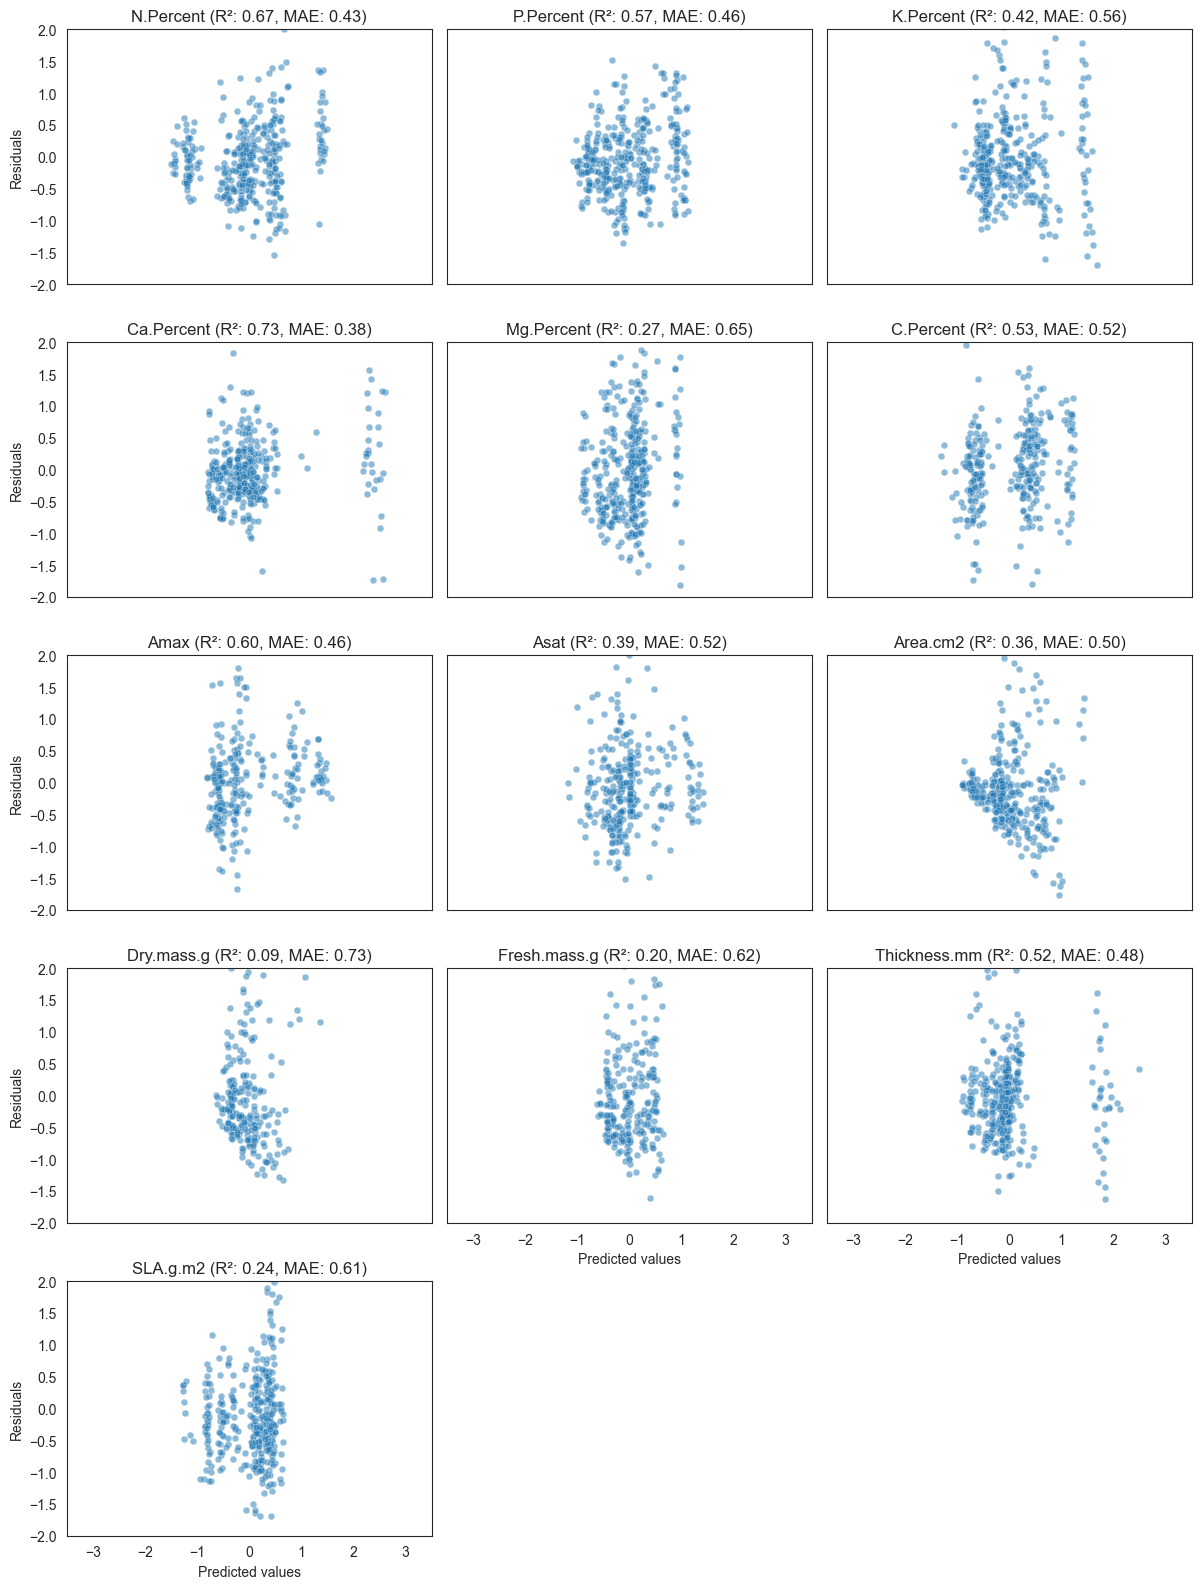

In [10]:
# Plot residuals for each different variable on a single plot
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 16))

# remove empty subplots
for j in range(len(VARS), len(axes.flat)):
    axes.flat[j].remove()

for i, var in enumerate(VARS):
    model = load_model(model_path, 42, var)
    var_stats = trait_stats[var]
    model.set_stats(var_stats)

    dataset = LabelledTraitData(
        data_path=Path('/Users/campbelli/Documents/geofm-plant-traits/data'),
        var=var
    )

    X_train, y_train = dataset.train_data, dataset.train_labels
    X_val, y_val = dataset.val_data, dataset.val_labels
    X_test, y_test = dataset.test_data, dataset.test_labels

    X_train, y_train = model.configure_data(X_train, y_train)
    X_val, y_val = model.configure_data(X_val, y_val)
    X_test, y_test = model.configure_data(X_test, y_test)
    
    # Uses optimised hyperparameters
    model.fit(X_train, y_train, X_val, y_val)
    preds = model.predict(X_test)

    # Calculate metrics.
    r_squared = model.score(X_test, y_test)
    mae = mean_absolute_error(y_test, preds)

    if type(preds) != np.ndarray:
        preds = preds.numpy().flatten()
        y_test = y_test.numpy().flatten()

    # Plot residuals
    residuals = y_test - preds
    ax = axes.flat[i]
    sns.scatterplot(x=preds, y=residuals, ax=ax, alpha=0.5, s=24)

    ax.set_title(f"{var} (R²: {r_squared:.2f}, MAE: {mae:.2f})")
    ax.set_ylim(-2., 2.)
    ax.set_xlim(-3.5, 3.5)

    # Set labels for last subplots in column.
    if i > 9:
        ax.set_xlabel("Predicted values")
        ax.set_xticks([-3, -2, -1, 0, 1, 2, 3])
    else:
        ax.set_xticklabels([])

    if i % 3 == 0:
        ax.set_ylabel("Residuals")
    else:
        ax.set_yticklabels([])

plt.savefig(f"../figures/models/residuals_{model_name}.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()